In [428]:
import os
import glob
from datetime import datetime
from datetime import timezone
import polars as pl
import plotly.express as px

start_date = datetime(2023, 10, 26, 0, 0, 0).replace(tzinfo=timezone.utc)
end_date = datetime(2023, 11, 26, 23, 59, 59).replace(tzinfo=timezone.utc)
id_system = 11

DATA_DIRECTORY = os.environ.get("DATA_DIRECTORY")
PICARRO_DATA_DIRECTORy = os.environ.get("PICARRO_DATA_DIRECTORY")

df_cal = pl.scan_parquet(os.path.join(DATA_DIRECTORY, "processed", "slope_intercept_acropolis.parquet"))

In [429]:
df_cal = df_cal.with_columns((pl.col("creation_timestamp").dt.timestamp("ms") / 3.6e6).alias("timestamp")) #3.6e6 ms are in 1h

#df_cal = df_cal.with_columns((pl.col("creation_timestamp").dt.timestamp().cast(pl.Float64)).alias("timestamp"))

In [430]:
df_sys = df_cal.filter(pl.col("system_name") == f"tum-esm-midcost-raspi-{id_system}").filter(pl.col("creation_timestamp").is_between(start_date, end_date))

In [431]:
fig = px.line(df_sys.collect(), x="date", y=f"slope", markers=True, title = "Slope")
fig.show()

fig = px.line(df_sys.collect(), x="date", y=f"intercept", markers=True, title = "Slope")
fig.show()

# Use RANSAC algortihm

Estimated coefficients (true, linear regression, RANSAC):
[-1.15622943e-06] [-1.1073318e-05]
[ True  True  True False  True  True  True  True  True  True  True  True
 False  True False  True False False  True  True False  True  True  True
 False  True False  True False  True]


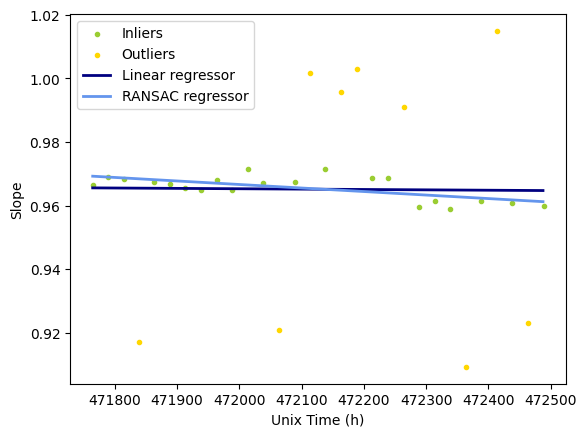

In [432]:
from sklearn import linear_model
import numpy as np

# ---- init ----

df_sys = df_cal.filter(pl.col("system_name") == f"tum-esm-midcost-raspi-{id_system}").filter(pl.col("creation_timestamp").is_between(start_date, end_date))

y = df_sys.select(pl.col("slope")).collect().to_series().to_list()
x = df_sys.select(pl.col("timestamp")).collect().to_series().to_list()

#x = range(len(y))

Y = np.array(y)
X = np.array(x)

# --------------

lr = linear_model.LinearRegression()
lr.fit(X.reshape(-1, 1), Y)


# Robustly fit linear model with RANSAC algorithm
ransac_slope = linear_model.RANSACRegressor(residual_threshold=0.02)
ransac_slope.fit(X.reshape(-1, 1), Y)
inlier_mask = ransac_slope.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)

# Predict data of estimated models
line_X = np.arange(X.min(), X.max())[:, np.newaxis]
line_y = lr.predict(line_X)
line_y_ransac = ransac_slope.predict(line_X)

# Compare estimated coefficients
print("Estimated coefficients (true, linear regression, RANSAC):")
print(lr.coef_, ransac_slope.estimator_.coef_)
print(inlier_mask)

lw = 2
#plt.gca().invert_yaxis() # Mirror points 

plt.scatter(
    X[inlier_mask], Y[inlier_mask], color="yellowgreen", marker=".", label="Inliers"
)
plt.scatter(
    X[outlier_mask], Y[outlier_mask], color="gold", marker=".", label="Outliers"
)
plt.plot(line_X, line_y, color="navy", linewidth=lw, label="Linear regressor")
plt.plot(
    line_X,
    line_y_ransac,
    color="cornflowerblue",
    linewidth=lw,
    label="RANSAC regressor",
)
plt.legend()
plt.xlabel("Unix Time (h)")
plt.ylabel("Slope")
plt.show()

Estimated coefficients (true, linear regression, RANSAC):
[-0.02440268] [-0.02345467]
[False False False False  True  True  True  True  True  True  True  True
 False  True False  True False False  True False False  True False  True
 False  True False  True False  True]


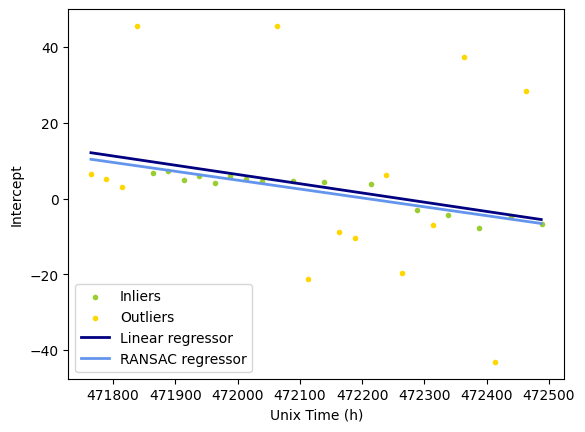

In [433]:
from sklearn import linear_model, datasets
import numpy as np

# ---- init ----

df_sys = df_cal.filter(pl.col("system_name") == f"tum-esm-midcost-raspi-{id_system}").filter(pl.col("creation_timestamp").is_between(start_date, end_date))

y = df_sys.select(pl.col("intercept")).collect().to_series().to_list()
x = df_sys.select(pl.col("timestamp")).collect().to_series().to_list()

Y = np.array(y)
X = np.array(x)

# --------------

lr = linear_model.LinearRegression()
lr.fit(X.reshape(-1, 1), Y)


# Robustly fit linear model with RANSAC algorithm
ransac_intercept = linear_model.RANSACRegressor()
ransac_intercept.fit(X.reshape(-1, 1), Y)
inlier_mask = ransac_intercept.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)

# Predict data of estimated models
line_X = np.arange(X.min(), X.max())[:, np.newaxis]
line_y = lr.predict(line_X)
line_y_ransac = ransac_intercept.predict(line_X)

# Compare estimated coefficients
print("Estimated coefficients (true, linear regression, RANSAC):")
print(lr.coef_, ransac_intercept.estimator_.coef_)
print(inlier_mask)

lw = 2
#plt.gca().invert_yaxis() # Mirror points 

plt.scatter(
    X[inlier_mask], Y[inlier_mask], color="yellowgreen", marker=".", label="Inliers"
)
plt.scatter(
    X[outlier_mask], Y[outlier_mask], color="gold", marker=".", label="Outliers"
)
plt.plot(line_X, line_y, color="navy", linewidth=lw, label="Linear regressor")
plt.plot(
    line_X,
    line_y_ransac,
    color="cornflowerblue",
    linewidth=lw,
    label="RANSAC regressor",
)
plt.legend()
plt.xlabel("Unix Time (h)")
plt.ylabel("Intercept")
plt.show()

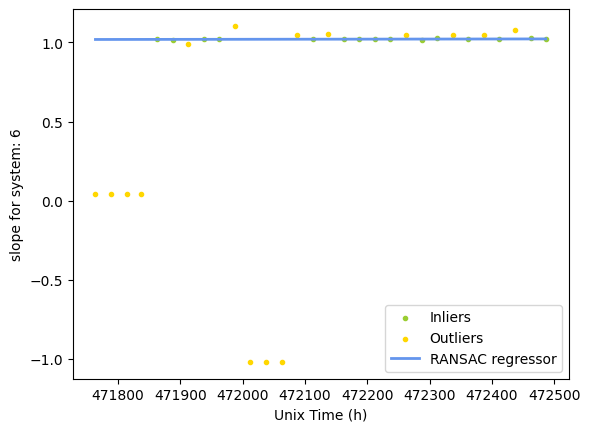

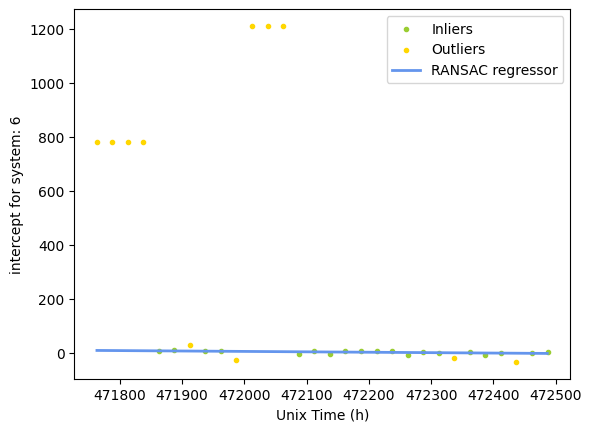

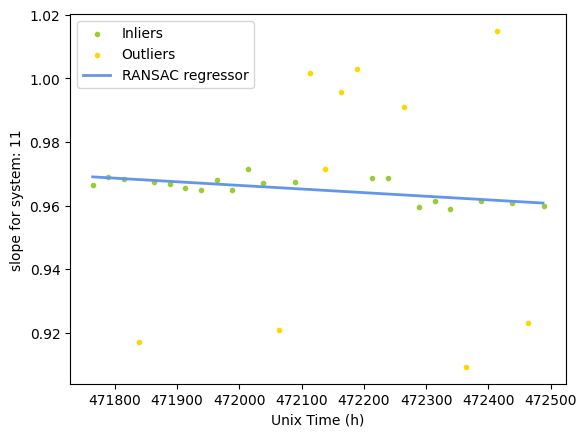

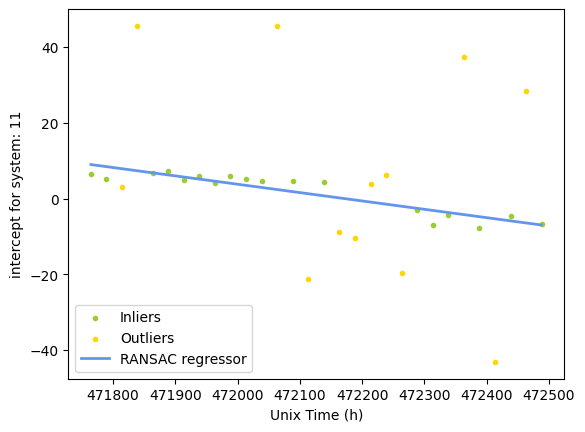

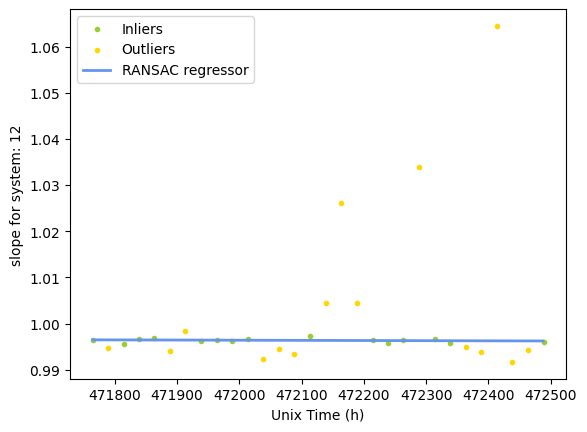

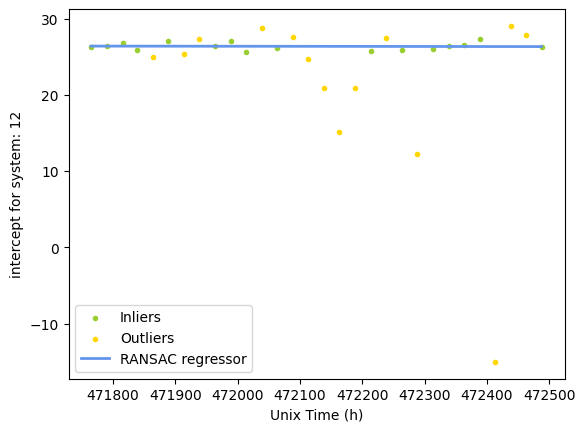

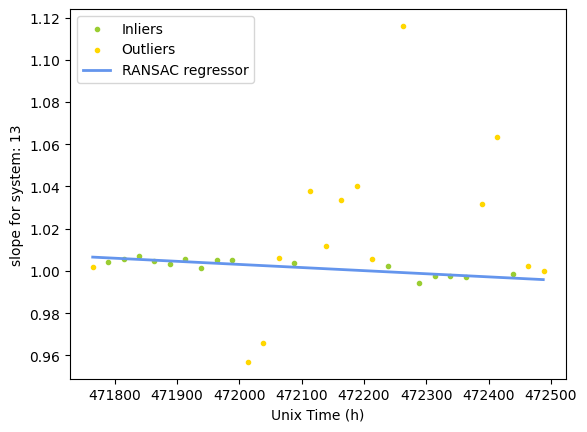

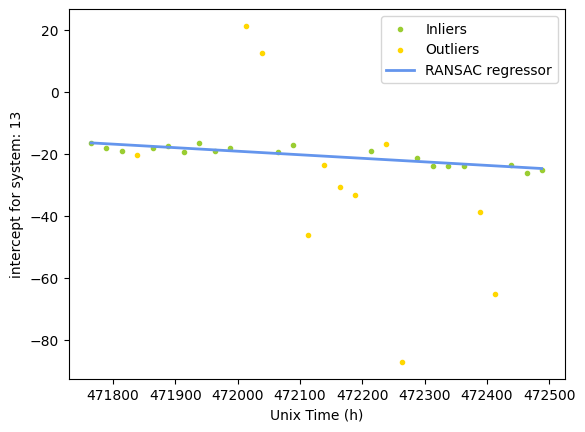

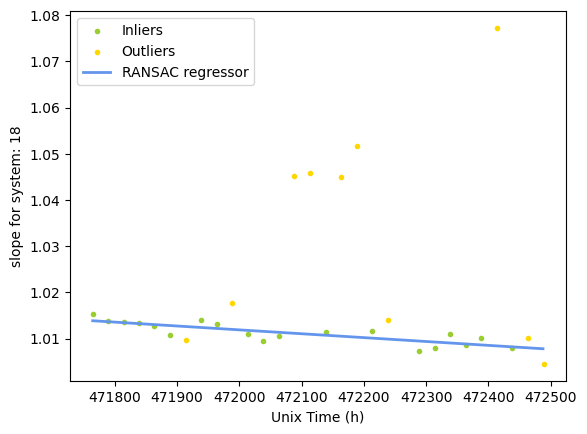

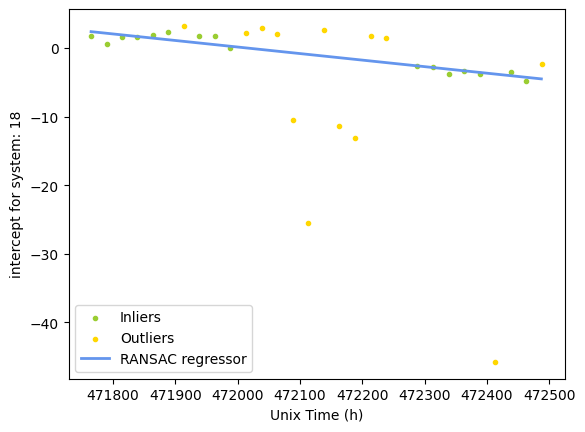

In [434]:
sensor_id = [6,11,12,13,18]

df_p_1h = pl.read_parquet(os.path.join(DATA_DIRECTORY,"processed", "1h_cal_corr_picarro.parquet")) \
    .filter(pl.col("creation_timestamp").is_between(start_date, end_date))

df_dry = pl.scan_parquet(os.path.join(DATA_DIRECTORY, "processed", "acropolis_dry.parquet")).filter(pl.col("creation_timestamp").is_between(start_date, end_date))

def calc_ransac(x, ransac):
    intercept = ransac.estimator_.intercept_
    slope = ransac.estimator_.coef_
    
    x = (x * slope) + intercept
    
    return x[0]

def fit_ransac(id_system, col):
    
    df_sys = df_cal.filter(pl.col("system_name") == f"tum-esm-midcost-raspi-{id_system}").filter(pl.col("creation_timestamp").is_between(start_date, end_date))

    y = df_sys.select(pl.col(col)).collect().to_series().to_list()
    x = df_sys.select(pl.col("timestamp")).collect().to_series().to_list()

    #x = range(len(y))

    Y = np.array(y)
    X = np.array(x)

    # Robustly fit linear model with RANSAC algorithm
    ransac = linear_model.RANSACRegressor()
    ransac.fit(X.reshape(-1, 1), Y)
    inlier_mask = ransac.inlier_mask_
    outlier_mask = np.logical_not(inlier_mask)
    line_X = np.arange(X.min(), X.max())[:, np.newaxis]
    line_y_ransac = ransac.predict(line_X)
    
    lw = 2
    

    plt.scatter(
        X[inlier_mask], Y[inlier_mask], color="yellowgreen", marker=".", label="Inliers"
    )
    plt.scatter(
        X[outlier_mask], Y[outlier_mask], color="gold", marker=".", label="Outliers"
    )
    plt.plot(
        line_X,
        line_y_ransac,
        color="cornflowerblue",
        linewidth=lw,
        label="RANSAC regressor",
    )
    plt.legend()
    plt.xlabel("Unix Time (h)")
    plt.ylabel(f"{col} for system: {id}")
    plt.show()
    
    return ransac


l_df_cal_corr =[df_p_1h]
    

for id in sensor_id:  
    ransac_slope = fit_ransac(id, "slope")
    ransac_intercept = fit_ransac(id, "intercept")
    
    df_cal_corr = df_dry.filter(pl.col("system_name") == f"tum-esm-midcost-raspi-{id}") \
        .with_columns((pl.col("creation_timestamp").dt.timestamp("ms") / 3.6e6).alias("unix_time_h")) \
        .with_columns((pl.col("unix_time_h").apply(lambda x: calc_ransac(x, ransac_slope))).alias("slope")) \
        .with_columns((pl.col("unix_time_h").apply(lambda x: calc_ransac(x, ransac_intercept))).alias("intercept")) \
        .with_columns((pl.col("gmp343_dry") * pl.col("slope") + pl.col("intercept")).alias("CO2_corr")) \
        .sort("creation_timestamp") \
        .select(["creation_timestamp", "system_name", "CO2_corr"]) \
        .groupby_dynamic("creation_timestamp", every='1h')  \
        .agg([
            pl.all().exclude(["creation_timestamp","system_name"]).mean(),
            pl.col("system_name")
            ]) \
        .with_columns(pl.col("system_name").list.last()) \
        .collect()
        
    df_cal_corr = df_cal_corr.join(df_p_1h.select("creation_timestamp", "CO2_corr") \
            .rename({"CO2_corr": "temp"}), on="creation_timestamp", how= "left") \
            .with_columns((pl.col("CO2_corr") - pl.col("temp")).alias("diff")) \
            .drop("temp")
        
    l_df_cal_corr.append(df_cal_corr)

In [435]:
df_cal_cor = pl.concat(l_df_cal_corr, how="diagonal")

In [436]:
import plotly.express as px

fig = px.line(df_cal_cor, x="creation_timestamp", y=f"CO2_corr", markers=True, title = "CO2", color="system_name")
fig.show()

fig = px.line(df_cal_cor, x="creation_timestamp", y=f"diff", markers=True, title = "CO2", color="system_name")
fig.show()

In [437]:
import math
from sklearn.metrics import r2_score

def rmse(y_true, y_meas):
    MSE = np.square(np.subtract(y_true, y_meas)).mean()
    RMSE = math.sqrt(MSE)

    return RMSE

def calc_r2(y_true, y_meas):
    return r2_score(y_true, y_meas)


for temp_id in sensor_id:

    print(f"\nAnalysis for System {temp_id}:")

    #----
    df_acropolis = df_cal_cor.filter(pl.col("system_name")==f"tum-esm-midcost-raspi-{temp_id}") \
        .select(["creation_timestamp", "CO2_corr"]) \
        .rename({"CO2_corr": f"CO2_acropolis_{temp_id}"})
        
    df_picarro = df_cal_cor.filter(pl.col("system_name")=="Picarro") \
        .select(["creation_timestamp", "CO2_corr"]) \
        .rename({"CO2_corr": f"CO2_picarro"})
        
    df_analysis = df_picarro.join(df_acropolis, on="creation_timestamp")  \
        .filter(pl.col("CO2_picarro") > 0)  \
        .filter(pl.col(f"CO2_acropolis_{temp_id}") > 0)
        
    l_picarro = df_analysis.select("CO2_picarro").to_series().to_list()
    l_acropolis = df_analysis.select(f"CO2_acropolis_{temp_id}").to_series().to_list()
    
    #----
    if len(l_acropolis) > 0:
        
        mean_offset = df_cal_cor.filter(pl.col("system_name")==f"tum-esm-midcost-raspi-{temp_id}").select("diff").mean().item()
        print(f"Offset {mean_offset}")
        
        rmse_result = rmse(l_picarro,l_acropolis)
        print(f"RMSE: {rmse_result}")
        
        r2_result = calc_r2(l_picarro,l_acropolis)
        print(f"R2: {r2_result}")


Analysis for System 6:
Offset -2.4126984546664043
RMSE: 3.8323749305361314
R2: 0.888968934352946

Analysis for System 11:
Offset 7.17091021209198
RMSE: 8.379108256466399
R2: 0.46923273512741026

Analysis for System 12:
Offset 11.32940106452093
RMSE: 11.379879607353795
R2: 0.02099736225132154

Analysis for System 13:
Offset -1.4249722825888198
RMSE: 3.184857847977368
R2: 0.923416470940002

Analysis for System 18:
Offset -1.3333869834893965
RMSE: 2.7339651335858925
R2: 0.9434940123377219


In [438]:
for temp_id in sensor_id:

    print(f"\nAnalysis for System {temp_id}:")

    #----
    mean_offset = 0
    if len(l_acropolis) > 0:
        mean_offset = df_cal_cor.filter(pl.col("system_name")==f"tum-esm-midcost-raspi-{temp_id}").select("diff").mean().item()
    
    df_acropolis = df_cal_cor.filter(pl.col("system_name")==f"tum-esm-midcost-raspi-{temp_id}") \
        .select(["creation_timestamp", "CO2_corr"]) \
        .with_columns(pl.col("CO2_corr") - mean_offset)  \
        .rename({"CO2_corr": f"CO2_acropolis_{temp_id}"})
        
    df_picarro = df_cal_cor.filter(pl.col("system_name")=="Picarro") \
        .select(["creation_timestamp", "CO2_corr"]) \
        .rename({"CO2_corr": f"CO2_picarro"})
        
    df_analysis = df_picarro.join(df_acropolis, on="creation_timestamp")  \
        .filter(pl.col("CO2_picarro") > 0)  \
        .filter(pl.col(f"CO2_acropolis_{temp_id}") > 0)
        
    l_picarro = df_analysis.select("CO2_picarro").to_series().to_list()
    l_acropolis = df_analysis.select(f"CO2_acropolis_{temp_id}").to_series().to_list()
    
    #----
    if len(l_acropolis) > 0:
        
        rmse_result = rmse(l_picarro,l_acropolis)
        print(f"RMSE: {rmse_result}")
        
        r2_result = calc_r2(l_picarro,l_acropolis)
        print(f"R2: {r2_result}")


Analysis for System 6:
RMSE: 2.9775801878458563
R2: 0.9329752104320592

Analysis for System 11:
RMSE: 4.334455202640619
R2: 0.8579708249471438

Analysis for System 12:
RMSE: 1.070668668215708
R2: 0.9913339994054728

Analysis for System 13:
RMSE: 2.848293086337261
R2: 0.9387473869077103

Analysis for System 18:
RMSE: 2.386764442487858
R2: 0.9569346833012166


# Perform RANSAC only on slope and then select valid calibrations

In [439]:
sensor_id = [6,11,12,13,18]


df_p_1h = pl.read_parquet(os.path.join(DATA_DIRECTORY,"processed", "1h_cal_corr_picarro.parquet")) \
    .filter(pl.col("creation_timestamp").is_between(start_date, end_date))

df_dry = pl.scan_parquet(os.path.join(DATA_DIRECTORY, "processed", "acropolis_dry.parquet")).filter(pl.col("creation_timestamp").is_between(start_date, end_date))


def fit_ransac(x, y):
    #x = range(len(y))

    Y = np.array(y)
    X = np.array(x)

    # Robustly fit linear model with RANSAC algorithm
    ransac = linear_model.RANSACRegressor(residual_threshold=0.01)
    ransac.fit(X.reshape(-1, 1), Y)
    inlier_mask = ransac.inlier_mask_
    outlier_mask = np.logical_not(inlier_mask)
    line_X = np.arange(X.min(), X.max())[:, np.newaxis]
    line_y_ransac = ransac.predict(line_X)
    
    # plot
    lw = 2
    
    plt.scatter(
        X[inlier_mask], Y[inlier_mask], color="yellowgreen", marker=".", label="Inliers"
    )
    plt.scatter(
        X[outlier_mask], Y[outlier_mask], color="gold", marker=".", label="Outliers"
    )
    plt.plot(
        line_X,
        line_y_ransac,
        color="cornflowerblue",
        linewidth=lw,
        label="RANSAC regressor",
    )
    plt.legend()
    plt.xlabel("Unix Time (h)")
    plt.ylabel(f"slope for system: {id}")
    plt.show()
    #----
    
    return inlier_mask

In [440]:
df_sys

<LazyFrame [6 cols, {"date": Date … "timestamp": Float64}] at 0x28D0DA650>

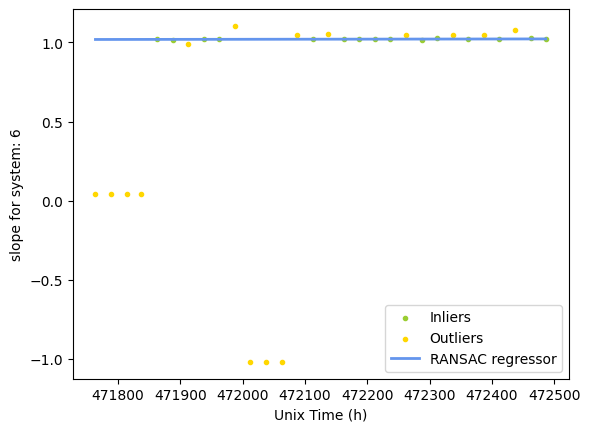

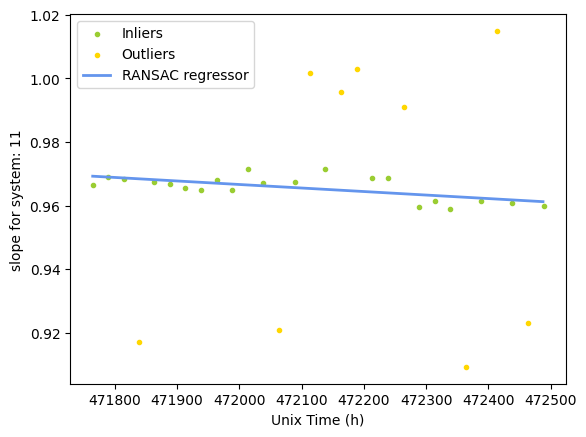

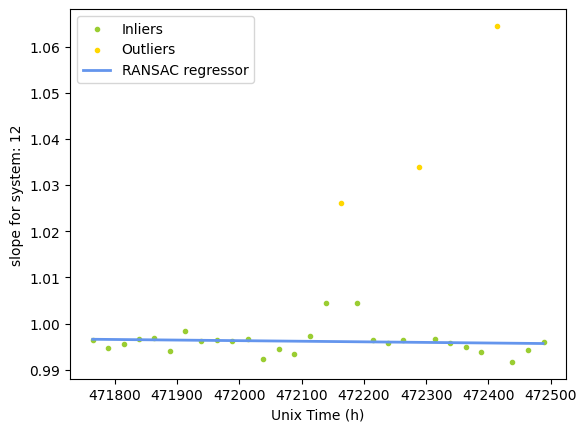

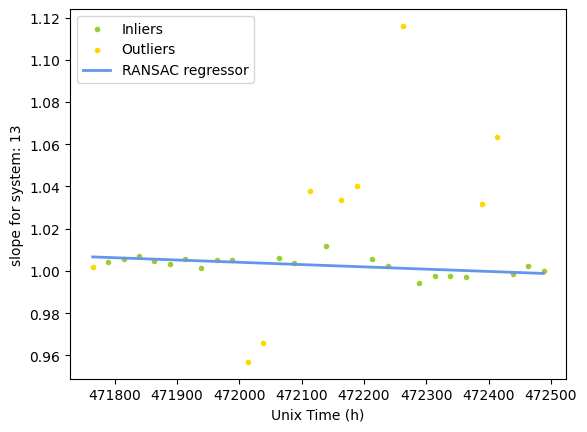

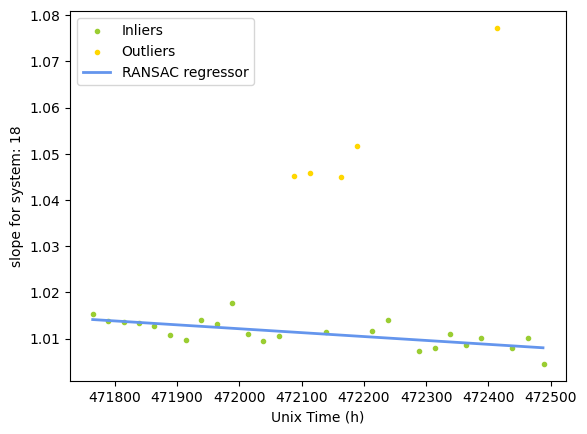

In [441]:
l_df_cor = []

for id in sensor_id:
    df_sys = df_cal.filter(pl.col("system_name") == f"tum-esm-midcost-raspi-{id}").filter(pl.col("creation_timestamp").is_between(start_date, end_date))

    y = df_sys.select(pl.col("slope")).collect().to_series().to_list()
    x = df_sys.select(pl.col("timestamp")).collect().to_series().to_list()

    mask = fit_ransac(x,y)

    df_sys = df_sys.with_columns(mask = pl.Series(mask)).collect()
    
    l_df_cor.append(df_sys)
    

df_cal_ransac = pl.concat(l_df_cor, how="diagonal")

In [442]:
df_cal_ransac = df_cal_ransac.with_columns((pl.col("slope") * pl.col("mask")).alias("ransac_slope")) \
    .with_columns((pl.col("intercept") * pl.col("mask")).alias("ransac_intercept")) \
    .filter(pl.col("mask") == True) \
    .sort("creation_timestamp") \
    .lazy()
    
df_cal_ransac

<LazyFrame [9 cols, {"date": Date … "ransac_intercept": Float64}] at 0x28B2A7B90>

In [443]:
sensor_id = [6,10,11,12,13,18,20]

df_p_1h = pl.read_parquet(os.path.join(DATA_DIRECTORY,"processed", "1h_cal_corr_picarro.parquet")) \
    .filter(pl.col("creation_timestamp").is_between(start_date, end_date))

df_dry = pl.scan_parquet(os.path.join(DATA_DIRECTORY, "processed", "acropolis_dry.parquet")).filter(pl.col("creation_timestamp").is_between(start_date, end_date))

In [444]:
# reduce timestamp to date DD.XX.YYYY for measurement dataset and join slope and intercept from df_cal
df_date = df_dry.filter(pl.col("gmp343_dry") > 0) \
    .with_columns(pl.col("creation_timestamp").dt.date().alias("date")) \
    .join(df_cal_ransac, on = ["date","system_name"], how= "left")
    
        
l_df_cal_corr =[df_p_1h]

for id in sensor_id:  
    # broadcast: via backward and forward fill
    # calibration correction: via coloumn operation 
    # aggregation: defined by filter
    # offset calculation to reference instrument PICARRO
    df_cal_corr = df_date.filter(pl.col("system_name") == f"tum-esm-midcost-raspi-{id}") \
    .fill_null(strategy = "backward") \
    .fill_null(strategy = "forward") \
    .with_columns(((pl.col("gmp343_dry")) * pl.col("slope") + pl.col("intercept")) \
    .alias("CO2_corr")) \
    .sort("creation_timestamp") \
    .groupby_dynamic("creation_timestamp", every='1h')  \
    .agg([
        pl.all().exclude(["creation_timestamp","system_name"]).mean(),
        pl.col("system_name")
        ]) \
    .with_columns(pl.col("system_name").list.last()) \
    .collect()
        
    df_cal_corr = df_cal_corr.join(df_p_1h.select("creation_timestamp", "CO2_corr") \
                .rename({"CO2_corr": "temp"}), on="creation_timestamp", how= "left") \
                .with_columns((pl.col("CO2_corr") - pl.col("temp")).alias("diff")) \
                .drop("temp")
        
    l_df_cal_corr.append(df_cal_corr)
        
    
df_cal_corr_agg = pl.concat(l_df_cal_corr, how="diagonal")
df_cal_corr_agg.write_parquet(os.path.join(DATA_DIRECTORY, "processed", "1h_cal_corr_acropolis.parquet"))


In [445]:
import plotly.express as px

fig = px.line(df_cal_corr_agg, x="creation_timestamp", y=f"CO2_corr", markers=True, title = "CO2", color="system_name")
fig.show()

fig = px.line(df_cal_corr_agg, x="creation_timestamp", y=f"diff", markers=True, title = "CO2", color="system_name")
fig.show()

In [446]:
import math
from sklearn.metrics import r2_score

def rmse(y_true, y_meas):
    MSE = np.square(np.subtract(y_true, y_meas)).mean()
    RMSE = math.sqrt(MSE)

    return RMSE

def calc_r2(y_true, y_meas):
    return r2_score(y_true, y_meas)


for temp_id in sensor_id:

    print(f"\nAnalysis for System {temp_id}:")

    #----
    df_acropolis = df_cal_cor.filter(pl.col("system_name")==f"tum-esm-midcost-raspi-{temp_id}") \
        .select(["creation_timestamp", "CO2_corr"]) \
        .rename({"CO2_corr": f"CO2_acropolis_{temp_id}"})
        
    df_picarro = df_cal_cor.filter(pl.col("system_name")=="Picarro") \
        .select(["creation_timestamp", "CO2_corr"]) \
        .rename({"CO2_corr": f"CO2_picarro"})
        
    df_analysis = df_picarro.join(df_acropolis, on="creation_timestamp")  \
        .filter(pl.col("CO2_picarro") > 0)  \
        .filter(pl.col(f"CO2_acropolis_{temp_id}") > 0)
        
    l_picarro = df_analysis.select("CO2_picarro").to_series().to_list()
    l_acropolis = df_analysis.select(f"CO2_acropolis_{temp_id}").to_series().to_list()
    
    #----
    if len(l_acropolis) > 0:
        
        mean_offset = df_cal_cor.filter(pl.col("system_name")==f"tum-esm-midcost-raspi-{temp_id}").select("diff").mean().item()
        print(f"Offset {mean_offset}")
        
        rmse_result = rmse(l_picarro,l_acropolis)
        print(f"RMSE: {rmse_result}")
        
        r2_result = calc_r2(l_picarro,l_acropolis)
        print(f"R2: {r2_result}")


Analysis for System 6:
Offset -2.4126984546664043
RMSE: 3.8323749305361314
R2: 0.888968934352946

Analysis for System 10:

Analysis for System 11:
Offset 7.17091021209198
RMSE: 8.379108256466399
R2: 0.46923273512741026

Analysis for System 12:
Offset 11.32940106452093
RMSE: 11.379879607353795
R2: 0.02099736225132154

Analysis for System 13:
Offset -1.4249722825888198
RMSE: 3.184857847977368
R2: 0.923416470940002

Analysis for System 18:
Offset -1.3333869834893965
RMSE: 2.7339651335858925
R2: 0.9434940123377219

Analysis for System 20:


In [447]:
for temp_id in sensor_id:

    print(f"\nAnalysis for System {temp_id}:")

    #----
    mean_offset = 0
    if len(l_acropolis) > 0:
        mean_offset = df_cal_cor.filter(pl.col("system_name")==f"tum-esm-midcost-raspi-{temp_id}").select("diff").mean().item()
    
    df_acropolis = df_cal_cor.filter(pl.col("system_name")==f"tum-esm-midcost-raspi-{temp_id}") \
        .select(["creation_timestamp", "CO2_corr"]) \
        .with_columns(pl.col("CO2_corr") - mean_offset)  \
        .rename({"CO2_corr": f"CO2_acropolis_{temp_id}"})
        
    df_picarro = df_cal_cor.filter(pl.col("system_name")=="Picarro") \
        .select(["creation_timestamp", "CO2_corr"]) \
        .rename({"CO2_corr": f"CO2_picarro"})
        
    df_analysis = df_picarro.join(df_acropolis, on="creation_timestamp")  \
        .filter(pl.col("CO2_picarro") > 0)  \
        .filter(pl.col(f"CO2_acropolis_{temp_id}") > 0)
        
    l_picarro = df_analysis.select("CO2_picarro").to_series().to_list()
    l_acropolis = df_analysis.select(f"CO2_acropolis_{temp_id}").to_series().to_list()
    
    #----
    if len(l_acropolis) > 0:
        
        rmse_result = rmse(l_picarro,l_acropolis)
        print(f"RMSE: {rmse_result}")
        
        r2_result = calc_r2(l_picarro,l_acropolis)
        print(f"R2: {r2_result}")


Analysis for System 6:
RMSE: 3.8323749305361314
R2: 0.888968934352946

Analysis for System 10:

Analysis for System 11:
RMSE: 8.379108256466399
R2: 0.46923273512741026

Analysis for System 12:
RMSE: 1.070668668215708
R2: 0.9913339994054728

Analysis for System 13:
RMSE: 2.848293086337261
R2: 0.9387473869077103

Analysis for System 18:
RMSE: 2.386764442487858
R2: 0.9569346833012166

Analysis for System 20:
